In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
from pathlib import Path
project_path = str(Path().resolve().parent)
sys.path.insert(0, project_path)
del project_path

from amasewavcal.mmnn import MmNn
from amasewavcal.wavcal_utils import detect_lines
from amasewavcal.wavcal_utils import find_nearest

In [3]:
# %matplotlib ipympl

### Wavelength Calibration: M-m-N-n Algorithm

#### Data

In [4]:
uncalibrated_spectrum = np.load('./data/uncalibrated_spectrum.npy')
spectrum_ys = np.arange(len(uncalibrated_spectrum))

#### Preparation

In [5]:
# M prominent emission lines with known wavelength
M_known_wls = np.array([
    6169.82, 6172.28, 6182.62, 6203.49, 6342.86, 6384.72, 6411.90,
    6416.31, 6457.28, 6531.34, 6554.16, 6577.21, 6583.91, 6588.54,
    6591.48, 6593.94, 6604.85, 6643.70, 6662.27, 6677.28, 6684.29,
    6727.46, 6752.83, 6756.45, 6766.61, 6780.41, 6871.29, 6911.23,
    6937.66, 6943.61, 6965.43, 6989.66,
])

# m most reliably detectable lines
m_known_wls = np.array([6182.62, 6583.91, 6588.54, 6591.48, 6752.83, 6871.29, 6965.43])

M, m = len(M_known_wls), len(m_known_wls)

In [6]:
# N significant peaks & n strongest peaks
N, n = 100, 20
N_peak_ys, _, n_peak_ys, _ = detect_lines(
    uncalibrated_spectrum, N=N, n=n,
)

N, n = len(N_peak_ys), len(n_peak_ys)

In [7]:
print('M m N n:', M, m, N, n)

M m N n: 32 7 100 20


#### Wavelength Calibration

In [8]:
# initialize
deg = 3
poly_form = np.polynomial.Legendre
wl_increases_with_y = True

# calibration
full_search = True
# full_search = False  # "fast mode"
parallel = True
n_jobs = -1
backend = 'loky'
peak_y_coor_lim = [0, 9600]

In [9]:
calibrator = MmNn(
    M_known_wls, m_known_wls, N_peak_ys, n_peak_ys, peak_y_coor_lim=peak_y_coor_lim,
    deg=deg, poly_form=poly_form, wl_increases_with_y=wl_increases_with_y,
)

In [10]:
%%time
calibrator.wavelength_calibration(
    full_search=full_search,
    parallel=parallel,
    n_jobs=n_jobs,
    backend=backend,
)

CPU times: user 17.1 s, sys: 1.35 s, total: 18.5 s
Wall time: 1min 27s


##### check the fitting result

In [11]:
print('solution:', calibrator.solution)
print('RMSE:', calibrator.solution_rmse)
print('monotonicity:', calibrator.solution_monotonicity)  # 1 if wl increases with y, -1 if decreases, and 0 if not monotonic.

solution: 6116.37619549 + 0.15444057·P₁(x) - (1.96762629e-06)·P₂(x) -
(1.08471193e-10)·P₃(x)
RMSE: 0.030683658802368605
monotonicity: 1


In [12]:
spectrum_wls = calibrator.solution(spectrum_ys)

In [13]:
_, m_matched_peak_wls, indices = find_nearest(m_known_wls, calibrator.solution(n_peak_ys))
m_matched_peak_ys = n_peak_ys[indices]
del indices

_, M_matched_peak_wls, indices = find_nearest(M_known_wls, calibrator.solution(N_peak_ys))
M_matched_peak_ys = N_peak_ys[indices]
del indices

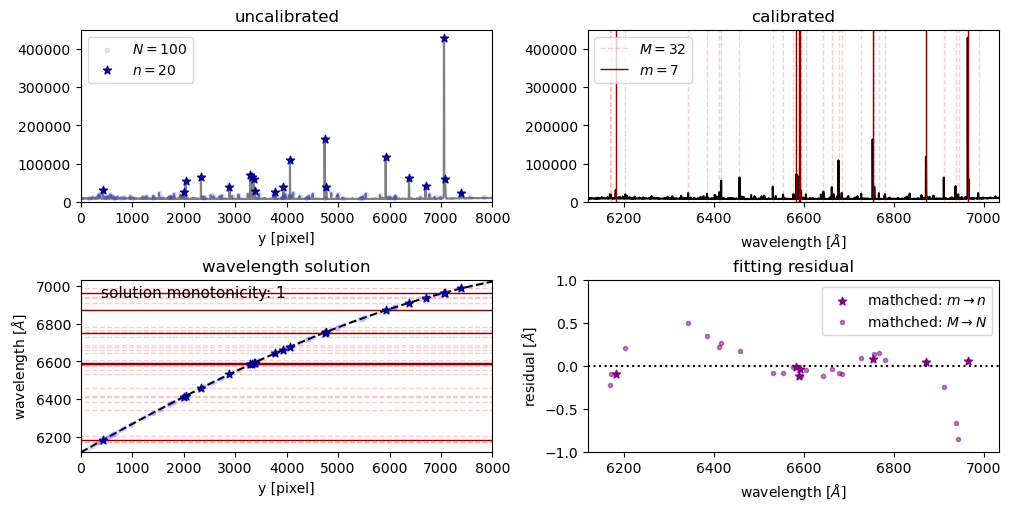

In [14]:
n_row, n_col = 2, 2
w, h, ratio = (n_col * 5.), (n_row * 2.5), 1.
w, h = w * ratio, h * ratio
fig, axes = plt.subplots(n_row, n_col, figsize=(w, h), sharex=False, sharey=False, layout='constrained')

# basic settings
y_coor_lim = [0., 8000.]
wl_lim = [6120., 7034.]

# un-calibrated
ax = axes[0, 0]
data_x = spectrum_ys
data_y = uncalibrated_spectrum
ax.plot(data_x, data_y, color='gray')
# ax.set_xlim(left=0.)
ax.set_ylim(bottom=0.)
ax.set_title('uncalibrated')
ax.set_xlabel('y [pixel]')

# calibrated
ax = axes[0, 1]
data_x = spectrum_wls
data_y = uncalibrated_spectrum
ax.plot(data_x, data_y, color='black')
ax.set_ylim(bottom=0.)
ax.set_title('calibrated')
ax.set_xlabel(r'wavelength [$\AA$]')

# M lines & m lines
ax = axes[0, 1]
ax.vlines(M_known_wls, ax.get_ylim()[0], ax.get_ylim()[1], color='red', linestyle='dashed', label=f'$M = {M}$', linewidth=1., alpha=0.2)
ax.vlines(m_known_wls, ax.get_ylim()[0], ax.get_ylim()[1], color='darkred', linestyle='solid', label=f'$m = {m}$', linewidth=1., alpha=1.)

# N peaks
ax = axes[0, 0]
data_x = spectrum_ys[N_peak_ys]
data_y = uncalibrated_spectrum[N_peak_ys]
ax.scatter(data_x, data_y, marker='.', color='blue', zorder=1000, label=f'$N = {N}$', alpha=0.1)

# n peaks
ax = axes[0, 0]
data_x = spectrum_ys[n_peak_ys]
data_y = uncalibrated_spectrum[n_peak_ys]
ax.scatter(data_x, data_y, marker='*', color='darkblue', zorder=1000, label=f'$n = {n}$')

# solution
ax = axes[1, 0]
data_x = np.arange(0., 10000., 0.1)
data_y = calibrator.solution(data_x)
ax.plot(data_x, data_y, color='black', linestyle='dashed')
ax.set_title('wavelength solution')
ax.set_xlabel('y [pixel]')
ax.set_ylabel(r'wavelength [$\AA$]')
info = f'solution monotonicity: {calibrator.solution_monotonicity:d}'
ax.text(0.05, 0.90, s=info, color='black', fontsize=11., transform=ax.transAxes)

# solution: N peaks
ax = axes[1, 0]
data_x = N_peak_ys
data_y = calibrator.solution(N_peak_ys)
ax.scatter(data_x, data_y, marker='.', color='blue', zorder=1000, label=f'$N = {N}$', alpha=0.1)

# solution: n peaks
ax = axes[1, 0]
data_x = n_peak_ys
data_y = calibrator.solution(n_peak_ys)
ax.scatter(data_x, data_y, marker='*', color='darkblue', zorder=1000, label=f'$n = {n}$')

# solution: M lines & m lines
ax = axes[1, 0]
ax.hlines(M_known_wls, ax.get_xlim()[0], ax.get_xlim()[1], color='red', linestyle='dashed', label=f'$M = {M}$', linewidth=1., alpha=0.2)
ax.hlines(m_known_wls, ax.get_xlim()[0], ax.get_xlim()[1], color='darkred', linestyle='solid', label=f'$m = {m}$', linewidth=1., alpha=1.)

# residuals: matched m
ax = axes[1, 1]
data_x = m_matched_peak_wls
data_y = m_matched_peak_wls - m_known_wls
ax.scatter(data_x, data_y, marker='*', color='purple', zorder=1000, label=r'mathched: $m \rightarrow n$')
ax.set_title('fitting residual')

# residuals: matched M
ax = axes[1, 1]
data_x = M_matched_peak_wls
data_y = M_matched_peak_wls - M_known_wls
ax.scatter(data_x, data_y, marker='.', color='purple', alpha=0.5, label=r'mathched: $M \rightarrow N$')

# settings
ax = axes[0, 0]
ax.legend(loc='upper left')
ax.set_xlim(y_coor_lim)
ax = axes[0, 1]
ax.legend(loc='upper left')
ax.set_xlim(wl_lim)
ax = axes[1, 0]
ax.set_xlim(y_coor_lim)
ax.set_ylim(wl_lim)
# ax.legend(loc='upper left')
ax = axes[1, 1]
ax.legend(loc='upper right')
ax.set_xlabel(r'wavelength [$\AA$]')
ax.set_xlim(wl_lim)
ax.set_ylabel(r'residual [$\AA$]')
ax.set_ylim([-1., 1.])
ax.hlines(0., ax.get_xlim()[0], ax.get_xlim()[1], color='black', linestyle='dotted')